# Forecasting attendances until 2040

## IMPORT PACKAGES

In [1]:
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [2]:
df = pd.read_csv('attendances_2016_2024.csv')
df.head()

,Date,A&E attendances Type 1,A&E attendances Type 2,A&E attendances Other A&E Department,Total A&E attendances
0,01/06/2015,"7,036",0,773,7809
1,01/07/2015,"7,422",0,777,8199
2,01/08/2015,"7,440",0,616,8056
3,01/09/2015,"7,340",0,733,8073
4,01/10/2015,"7,536",0,740,8276


In [3]:
#subset totals
data=df[['Date','Total A&E attendances']]

## Prophet Decomposition

In [4]:
# lockdowns in the UK as defined by the goverment
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-23', 'lower_window': 0,'ds_upper': '2021-03-28'}
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-23,0,2021-03-28,370


C:\Users\mifab\AppData\Local\Temp\ipykernel_15952\380962491.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')  # Convert date column
C:\Users\mifab\AppData\Local\Temp\ipykernel_15952\380962491.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Total A&E attendances'] = (
12:46:30 - cmdstanpy - INFO - Chain [1] start processing
12:46:30 - cmdstanpy - INFO - Chain [1] done processing


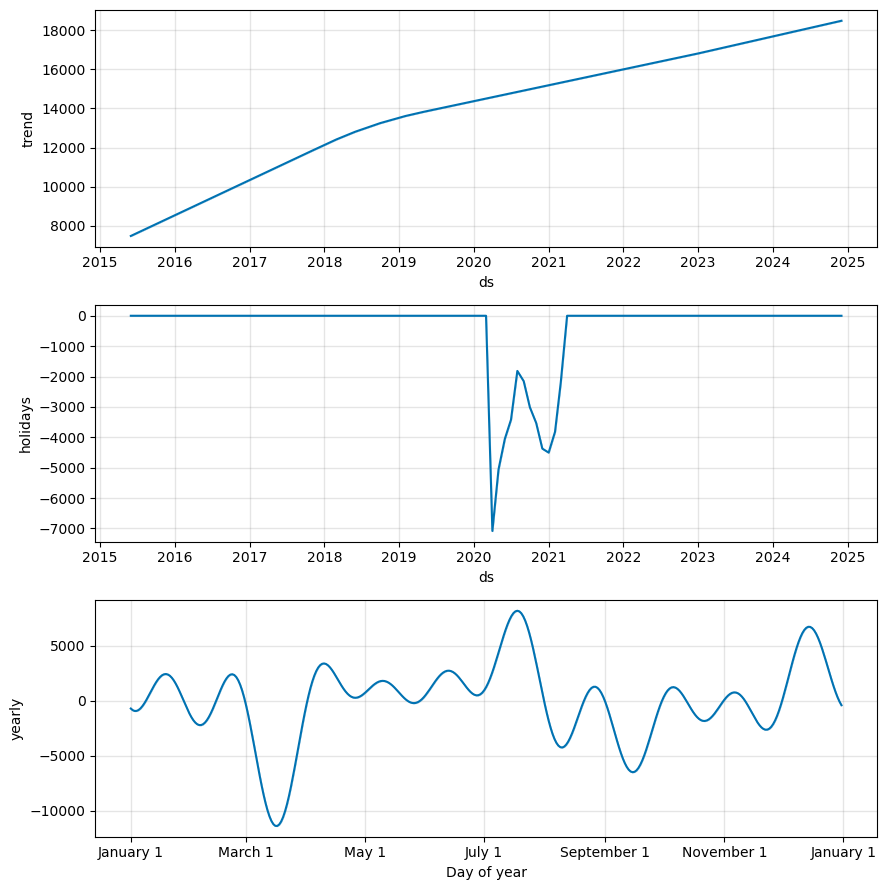

In [5]:
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')  # Convert date column
data['Total A&E attendances'] = (
    data['Total A&E attendances'].astype(str).str.replace(',', '').astype(int)  # Convert to numeric
)

# Rename columns for Prophet
data_prepared = data.rename(columns={'Date': 'ds', 'Total A&E attendances': 'y'})

# Initialise and fit the Prophet model
model = Prophet(holidays=lockdowns)
model.fit(data_prepared)

# Forecast and decompose
future = model.make_future_dataframe(periods=0)  # No forecasting, only decomposition
forecast = model.predict(future)

# Plot the components: trend, seasonality, and residuals
model.plot_components(forecast)
plt.show()

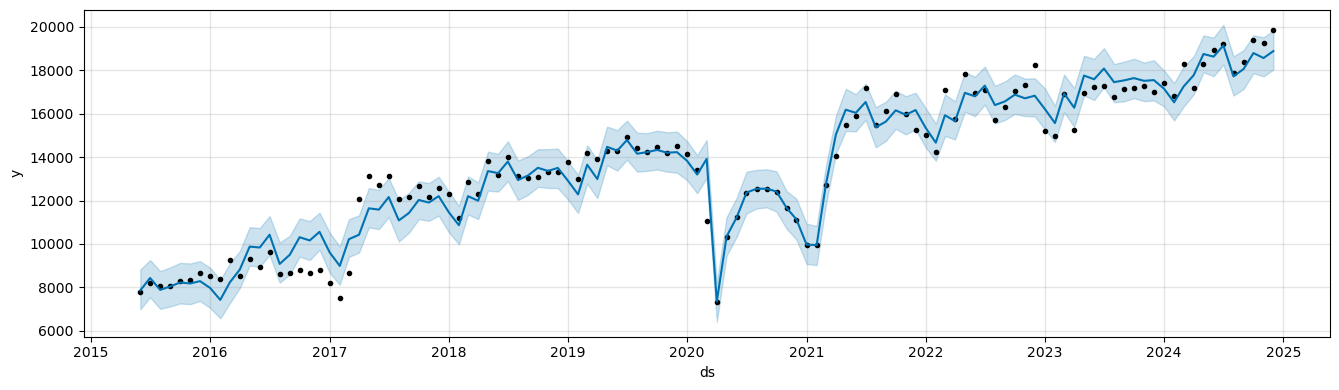

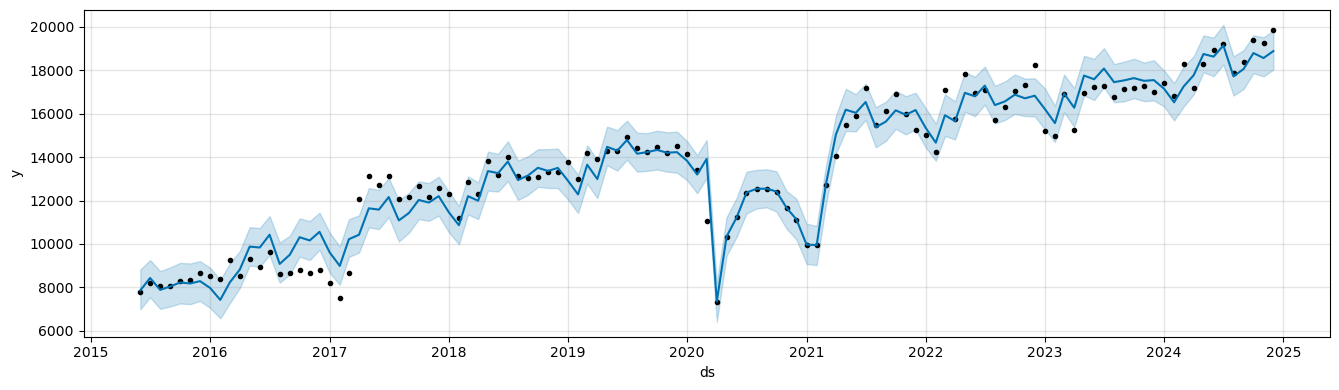

In [6]:
model.plot(forecast,figsize=(13.5, 4))

## MONTE CARLO Forecasting

In [4]:
#format and group data
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
yearly_data=data.groupby(data.Date.dt.year).sum().reset_index()[1:]
yearly_data['Date'] = pd.to_datetime(yearly_data['Date'], format='%Y')

C:\Users\mifab\AppData\Local\Temp\ipykernel_9384\580089884.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')


In [5]:
# Example: Historical A&E attendances from 2016 to 2024 (replace with your actual data)
historical_years = np.array(yearly_data.Date)
historical_attendances = np.array(yearly_data["Total A&E attendances"])  # Including COVID drop in 2020 and 2021a

# Constants
population_2022 = 907660  # Population in 2022
population_2041 = 1059570  # Population in 2041
years = np.arange(2024, 2041)  # Time from 2024 to 2040 (forecast period)
max_attendance_percentage=historical_attendances[-3]*100/population_2022 # %of attendances to total population in 2022

In [6]:
# Calculate growth rates
# Growth rate for 2016-2019 (pre-COVID) -- between 2016-2017, 2017-2018, and 2018-2019
growth_rate_pre_covid = (historical_attendances[1:4] - historical_attendances[:3]) / historical_attendances[:3]

# Growth rate for 2022-2024 (post-COVID)
growth_rate_post_covid = (historical_attendances[6:8] - historical_attendances[5:7]) / historical_attendances[5:7]

#combine both growth rates by taking a weighted average or simply using both sets of growth rates
combined_growth_rates = np.concatenate([growth_rate_pre_covid, growth_rate_post_covid])
# Estimate the average and standard deviation of the growth rate (from 2016-2019)
mean_growth_rate = np.mean(combined_growth_rates)
std_dev_growth_rate = np.std(combined_growth_rates)

# Population growth for 2024-2041 (calculated from known population figures)
k = (population_2041 - population_2022) / np.log(2041 - 2022 + 1)

# Number of simulations (Monte Carlo iterations)
num_simulations = 10000

# Prepare an array to store the results
simulated_attendances = np.zeros((num_simulations, len(years)))

# Correct the starting value for N_2024, which should be based on 2024 attendance (not 2022)
N_2024 = historical_attendances[-1]  # Attendance in 2024 (historical data)

In [7]:
# Monte Carlo Simulation to forecast A&E attendances based on historical growth and population growth
for i in range(num_simulations):
    # Random growth rate for A&E attendances using mean and std from historical growth rates
    r = np.random.normal(mean_growth_rate, std_dev_growth_rate)
    
    # Calculate attendances for each year using the historical growth rates and population growth
    for t_idx, t in enumerate(years):
        # Forecast the attendance for the current year using the random growth rate and population growth
        if t_idx == 0:
            # Start the forecast at the 2024 value (last historical data point)
            simulated_attendances[i, t_idx] = N_2024
        else:
            # Apply the random growth rate and population growth factor to the previous year's forecast
            
            population_for_year = population_2022 + k * np.log(t - 2022 + 1)
            population_previous_year = population_2022 + k * np.log((t - 1) - 2022 + 1)

            population_growth_factor= ((population_for_year-population_previous_year)/population_previous_year)
            
            # Logarithmic growth function to simulate saturation
            predicted_attendance = simulated_attendances[i, t_idx - 1] * (1 + r) * (1+population_growth_factor)
            
            # Dynamically adjust the saturation point to ensure earlier saturation
            saturation_point_factor =0.1

            saturation_point = population_for_year * max_attendance_percentage * saturation_point_factor  # Dynamic saturation
            
            # Apply the logarithmic saturation formula: ln(1 + x) to ensure growth slows down over time
            predicted_attendance = saturation_point * np.log(1 + predicted_attendance / saturation_point)
            
            # Store the result in the simulation matrix
            simulated_attendances[i, t_idx] = predicted_attendance

In [8]:
# Calculate the mean and 95% confidence intervals for the forecast
mean_attendance = np.mean(simulated_attendances, axis=0)
# 1std
lower_bound_1std = np.percentile(simulated_attendances, 16, axis=0)
upper_bound_1std = np.percentile(simulated_attendances, 84, axis=0)

# 2std
lower_bound_2std = np.percentile(simulated_attendances, 2.25, axis=0)
upper_bound_2std = np.percentile(simulated_attendances, 97.5, axis=0)

In [9]:
# Formatter function for y-axis ticks
def format_millions(x, pos):
    return f"{x / 1e6:.1f}M"  # Converts to millions with one decimal place

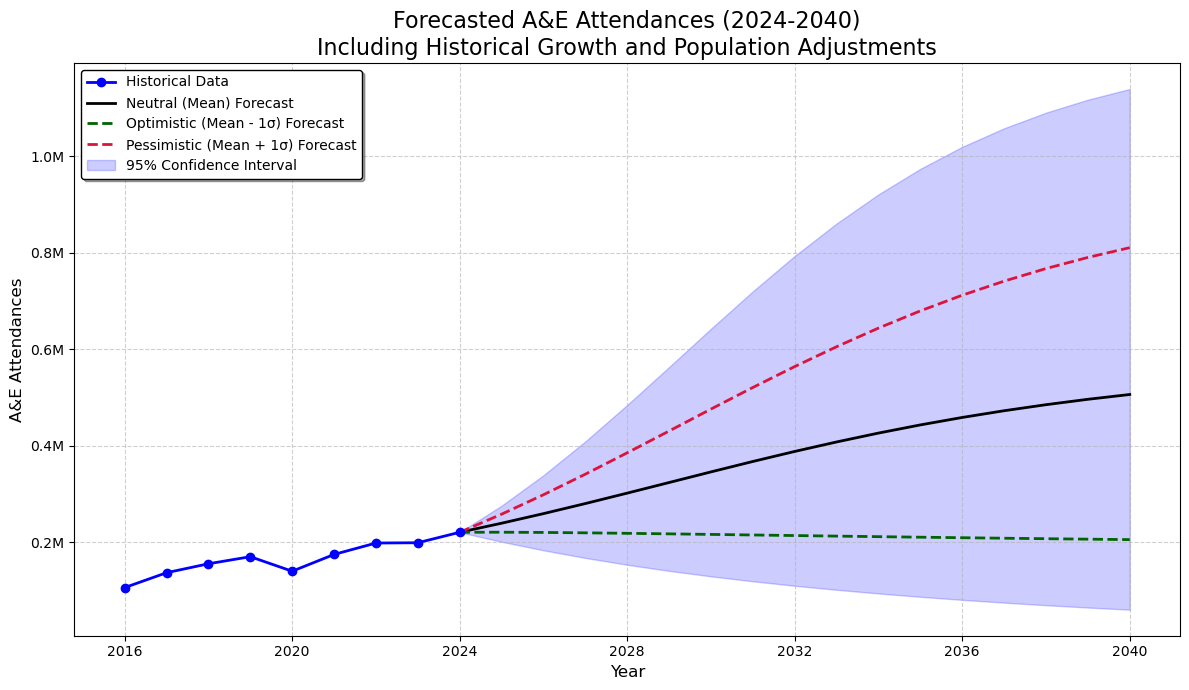

In [20]:
#fix for plot
years=pd.to_datetime(years, format='%Y')

# Plot the results
plt.figure(figsize=(12, 7))

# Plot the historical data (2016-2024)
plt.plot(historical_years, historical_attendances, color='blue', label="Historical Data", linewidth=2, zorder=5, marker='o')

# Plot the forecasted data (2024-2041)
plt.plot(years, mean_attendance, label="Neutral (Mean) Forecast", color='k', linewidth=2)
plt.plot(years, lower_bound_1std, label="Optimistic (Mean - 1σ) Forecast", color='darkgreen', linewidth=2, linestyle='--')
plt.plot(years, upper_bound_1std, label="Pessimistic (Mean + 1σ) Forecast", color='crimson', linewidth=2, linestyle='--')

# Plot the confidence interval as a shaded region
plt.fill_between(years, lower_bound_2std, upper_bound_2std, color='blue', alpha=0.2, label="95% Confidence Interval")

# Titles and labels
plt.title("Forecasted A&E Attendances (2024-2040)\nIncluding Historical Growth and Population Adjustments", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("A&E Attendances", fontsize=12)

# Customize the legend
plt.legend(loc='upper left', fontsize=10, frameon=True, shadow=True, edgecolor='black')

# Format the ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_millions))

# Add a grid
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()


In [22]:
# Calculate the mean and 95% confidence intervals for the forecast
neutral = (np.mean(simulated_attendances, axis=0)-historical_attendances[-1])*100/historical_attendances[-1]
optimistic = (np.percentile(simulated_attendances, 16, axis=0)-historical_attendances[-1])*100/historical_attendances[-1]
pessimistic = (np.percentile(simulated_attendances, 84, axis=0)-historical_attendances[-1])*100/historical_attendances[-1]

results=pd.DataFrame([optimistic,neutral,pessimistic],columns=years)
display(results)

,2024-01-01,2025-01-01,2026-01-01,2027-01-01,2028-01-01,2029-01-01,2030-01-01,2031-01-01,2032-01-01,2033-01-01,2034-01-01,2035-01-01,2036-01-01,2037-01-01,2038-01-01,2039-01-01,2040-01-01
0,0.0,0.064855,-0.151436,-0.519858,-0.973680,-1.474774,-1.999923,-2.534389,-3.068559,-3.596076,-4.112713,-4.615690,-5.103216,-5.574197,-6.028030,-6.464464,-6.883497
1,0.0,8.519444,17.513755,26.956818,36.740137,46.704969,56.666804,66.438558,75.850811,84.766182,93.086384,100.752592,107.741088,114.056417,119.723917,124.782801,129.280399
2,0.0,17.009573,35.236078,54.510104,74.562242,95.056646,115.622191,135.884039,155.493154,174.150299,191.621982,207.747405,222.437234,235.666085,247.461210,257.889643,267.045650
